Hunter Bennett | Glass Lab | Kupffer Strains | 08 Feb 2021

In [5]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [6]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/04_Strains_AMLNtoControl/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [7]:
df, mat = read_annotated_peaks(
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')

In [8]:
mat.columns

Index(['/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDi

In [9]:
best_reps = ['00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
       '01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
       '02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
       '02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
       '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
       '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423',
       '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb14D_180423',
       '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb6AB_180423',
       '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15B_180423',
       '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ6A_180423']

In [10]:
groups = [[0,1],
         [2,3],
         [4,5],
         [6,7],
         [8,9],
         [10,11]]
thresh = 16

Check that we are selecting the proper samples and the column order since we need this info for running get diff expressssion.

In [11]:
strains = ['C57', 'balbc', 'aj']
df, mat = read_annotated_peaks(
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')
df.index.rename('PeakID')
# drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > thresh, :].index.tolist())
df = df.reindex(list(set(peaks)))
df = df.dropna(how='all')
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

for strain in strains:
    print(strain)
    # pull out selected strain
    tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains(strain))
    # print(tst)
    tmp = df.loc[:, tst]
    print(tmp.columns)
    tmp.to_csv(
        './merged_peaks/'+strain+'_ann_raw_amln_control_idr_atac_peaks_merged.txt',
        sep='\t')

73615 total peaks
filtering low tag count peaks
61029 total peaks
C57
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423'],
      dtype='object')
balbc
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Rat

#### Run getDifferentialExpression for all samples

In [12]:
%%bash

source activate deseq_36
getDiffExpression.pl ./merged_peaks/C57_ann_raw_amln_control_idr_atac_peaks_merged.txt \
00_c57_control 00_c57_control \
01_c57_amln 01_c57_amln \
-peaks > ./merged_peaks/C57_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_c57_control vs. 01_c57_amln:
		Total Genes: 61029
		Total Up-regulated in 01_c57_amln vs. 00_c57_control: 4945 (8.103%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_c57_amln vs. 00_c57_control: 3614 (5.922%) [log2fold<-1, FDR<0.05]



In [13]:
%%bash

source activate deseq_36
getDiffExpression.pl ./merged_peaks/balbc_ann_raw_amln_control_idr_atac_peaks_merged.txt \
00_balbc_control 00_balbc_control \
01_balbc_amln 01_balbc_amln \
-peaks > ./merged_peaks/balbc_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbc_control vs. 01_balbc_amln:
		Total Genes: 61029
		Total Up-regulated in 01_balbc_amln vs. 00_balbc_control: 162 (0.265%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_balbc_amln vs. 00_balbc_control: 140 (0.229%) [log2fold<-1, FDR<0.05]



In [14]:
%%bash

source activate deseq_36
getDiffExpression.pl ./merged_peaks/aj_ann_raw_amln_control_idr_atac_peaks_merged.txt \
00_aj_control 00_aj_control \
00_aj_amln 00_aj_amln \
-peaks > ./merged_peaks/aj_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_aj_control vs. 00_aj_amln:
		Total Genes: 61029
		Total Up-regulated in 00_aj_amln vs. 00_aj_control: 2396 (3.926%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 00_aj_amln vs. 00_aj_control: 1630 (2.671%) [log2fold<-1, FDR<0.05]



# Scatter plot of differentially acetylated enhancers

## C57

In [36]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/C57_diff_output.txt',
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)


dict_keys(['00_c57_control vs. 01_c57_amln'])

In [37]:
comps = ['00_c57_control vs. 01_c57_amln']

cols = [[0,1,6,7]]

groups = [[[0,1],[6,7]]]

colors = [['#006d2c', '#006d2c']]

00_c57_control vs. 01_c57_amln
N peaks downregulated 3614
N peaks upregulated 4945



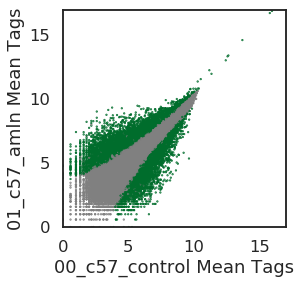

In [38]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N peaks upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## AJ

In [39]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/aj_diff_output.txt',
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)


dict_keys(['00_aj_control vs. 00_aj_amln'])

In [40]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

dict_keys(['00_aj_control vs. 00_aj_amln'])

In [41]:
comps = ['00_aj_control vs. 00_aj_amln']

cols = [[4,5,10,11]]

groups = [[[4,5],[10,11]]]

colors = [['#a50f15', '#a50f15']]

00_aj_control vs. 00_aj_amln
N peaks downregulated 1630
N peaks upregulated 2396



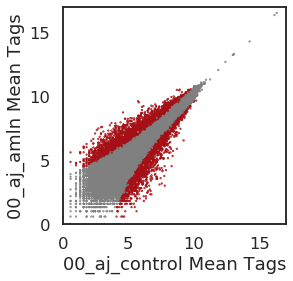

In [42]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N peaks upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## BALBc

In [43]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/balbc_diff_output.txt',
    './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)


dict_keys(['00_balbc_control vs. 01_balbc_amln'])

In [44]:
comps = ['00_balbc_control vs. 01_balbc_amln']

cols = [[2,3,8,9]]

groups = [[[2,3],[8,9]]]

colors = [['#08519c', '#08519c']]

00_balbc_control vs. 01_balbc_amln
N peaks downregulated 140
N peaks upregulated 162



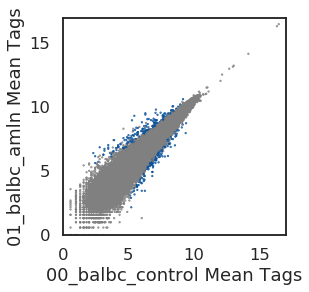

In [45]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N peaks upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Plot venn diagram of upregulated and downregulated peaks

In [35]:
from matplotlib_venn import venn3

## Extract all peaks that have significant differences in acetylation

Iterate through the three DESeq2 outputs and select differential peaks, store in the peak dict for processing

In [30]:
# set p value and log2fcs
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./merged_peaks/*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './merged_peaks/ann_raw_amln_control_idr_atac_peaks_merged.txt')
    
    # extract distal peaks only
    diff_peak = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # activated peaks stored in the [0] position.
    peak_dict[i.split('/')[-1].split('_')[0].replace('./','')] = [act, rep]

annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)
annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)
annotatePeaks all peaks (75050, 30)
getDiffExpression selected transcripts (61029, 25)
annotatePeaks selected peaks (61029, 30)


### Venn diagram for activated peaks
Generate the set values manually because I'm not a good enough programmer to do this on my own.

In [31]:
from matplotlib_venn import venn3

In [32]:
# all3 = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]))
# C57_balbc = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).difference(all3))
# C57_aj = set(peak_dict['C57'][0]).intersection(set(peak_dict['aj'][0]).difference(all3))
# balbc_aj = set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]).difference(all3)
# C57_private = set(peak_dict['C57'][0]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
# balbc_private = set(peak_dict['balbc'][0]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
# aj_private = set(peak_dict['aj'][0]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [33]:
peak_dict.keys()

dict_keys(['C57', 'aj', 'balbc'])

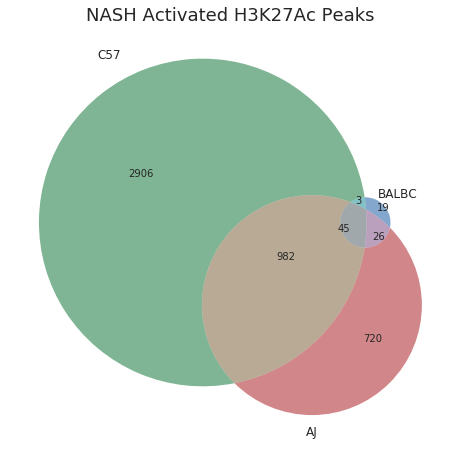

In [34]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['C57'][0]),
               set(peak_dict['balbc'][0]),
               set(peak_dict['aj'][0])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated H3K27Ac Peaks');

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')

In [35]:
# all3 = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]))
# C57_balbc = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).difference(all3))
# C57_aj = set(peak_dict['C57'][1]).intersection(set(peak_dict['aj'][1]).difference(all3))
# balbc_aj = set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]).difference(all3)
# C57_private = set(peak_dict['C57'][1]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
# balbc_private = set(peak_dict['balbc'][1]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
# aj_private = set(peak_dict['aj'][1]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

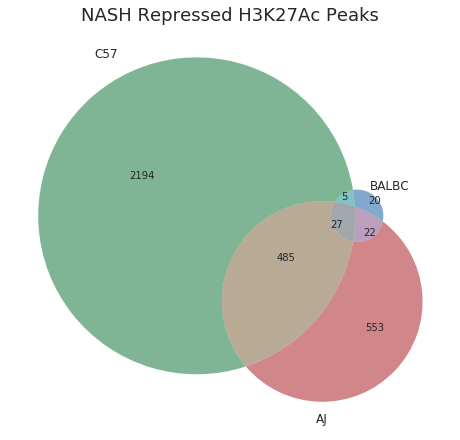

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['C57'][1]),
               set(peak_dict['balbc'][1]),
               set(peak_dict['aj'][1])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed H3K27Ac Peaks');

plt.savefig('./figures/venn3_repressed_peaks.png', bbox_inches='tight')